In [198]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pandas import DataFrame, read_csv, set_option as pdopt, cut as pdcut
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from logging import getLogger, ERROR
from matplotlib import pyplot as plt
from warnings import filterwarnings
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from random import randint
import mlflow.sklearn
import numpy as np
import mlflow

mlflow.set_experiment("Bank Telemarketing Predictions")


# show real numbers instead of numbers in scientific notation, to the second decimal point
pdopt('display.float_format', '{:.2f}'.format)

# set max rows
pdopt('display.max_rows', 1000)

# set max cols
pdopt('display.max_columns', None)

# set logging level for mlflow and filter out autolog from warnings to keep notebook tidy
getLogger("mlflow").setLevel(ERROR)
getLogger("mlflow.utils.autologging_utils").setLevel(ERROR)
filterwarnings("ignore", message=".*autolog.*")

In [199]:
df = read_csv("./data/Bank-Telemarketing.csv")

In [200]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [201]:
df.head(1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no


In [202]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [203]:
df["education"].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

In [204]:

with mlflow.start_run(run_name="data_preprocessing"):
    mlflow.log_param("age_bins", [0, 17, 25, 60, 120])
    mlflow.log_param("labels", ["Youth", "Adult", "Older Adult", "Senior"])

In [205]:
df["age_group"] = pdcut(
    df["age"],
    bins=age_bins,
    labels=labels,
    right=True,
    include_lowest=True)

df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Older Adult
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Adult
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no,Adult


<Axes: >

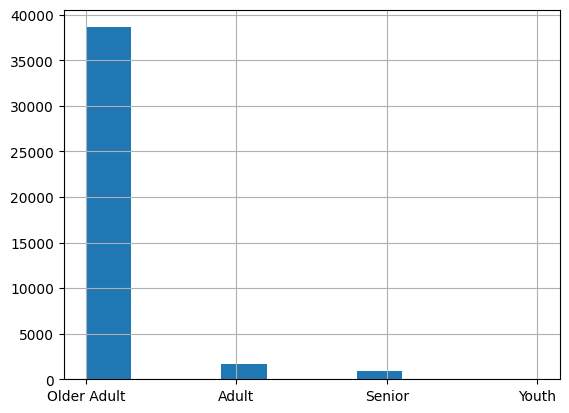

In [206]:
df["age_group"].hist()

In [207]:
# This class intakes a model and runs the prediction function upon itself. It is intended to run multiple times.
class MultiModelPredictor(BaseEstimator, ClassifierMixin):
    def __init__(self, model=None):
        # The candidate model is passed in.
        self.model = model

    def fit(self, X, y):
        # Clones the candidate model and fit it.
        self.model_ = clone(self.model)
        self.model_.fit(X, y)
        # Returns an instance of the updated object
        return self

    def predict(self, X):
        return self.model_.predict(X)


    # Explicitly define predict_proba clearly
    def predict_proba(self, X):
        if hasattr(self.model_, 'predict_proba'):
            return self.model_.predict_proba(X)
        else:
            raise AttributeError(f"The model {self.model_} does not implement predict_proba.")

In [208]:
categorical_imputer = ("cat_imputer", SimpleImputer(strategy="most_frequent"))
one_hot_encoder = ("cat_encoder", OneHotEncoder(handle_unknown="ignore"))
numeric_imputer = ("num_imputer", SimpleImputer(strategy="median"))
ordinal_encoder = ("ord_encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
scaler = ("scaler", StandardScaler())

features = {
    "target": "y",
    "categorical": ["job", "marital", "education", "contact", "month", "day_of_week", 
                    "campaign", "pdays", "previous", "poutcome", "previous"],
    "numerical": ["age", "duration", "euribor3m", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "pdays", "nr.employed"],
    "ordinal": ["default", "housing", "loan"]
}

In [209]:
numeric_imputer_scaler_pl = Pipeline(steps=[numeric_imputer, scaler])
categorical_imputer_pl = Pipeline(steps=[categorical_imputer, one_hot_encoder])
ordinal_encoder_pl = Pipeline(steps=[ordinal_encoder])

numeric_imputer_scaler = ("numeric_imputer_scaler", numeric_imputer_scaler_pl, features["numerical"])
categorical_imputer_encoder = ("categorical_imputer_encoder", categorical_imputer_pl, features["categorical"])
ordinal_encoder = ("ordinal_encoder", ordinal_encoder_pl, features["ordinal"])

In [210]:
# In this way, changing the target variable is as simple as updating the features dict
y = df[features["target"]].map({"no": 0, "yes": 1})
X = df.drop(features["target"], axis=1)

In [211]:
# Pipeline including preprocessing and RandomForestClassifier
preprocessor = ColumnTransformer(transformers=[
    numeric_imputer_scaler,
    categorical_imputer_encoder,
    ordinal_encoder
])

pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])


# Fit the pipeline
pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_imputer_scaler',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'duration',
                                                   'euribor3m', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'pdays',
                                                   'nr.employed']),
                                                 ('categorical_imputer_encoder',
                                                  Pipeline(steps=[('cat_imputer',...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education', 'contact',
                                                   'month', 'day_of_week',
                                                   'campaign', 'pdays',
                                                   'previous', 'poutcome',
                                                   'previous']),
                                                 ('ordinal_encoder',
                                                  Pipeline(steps=[('ord_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['default', 'housing',
                                                   'loan'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [212]:
# Extract feature importances from the trained classifier
importances = pipeline.named_steps["classifier"].feature_importances_

# Correct transformer name: "categorical_imputer_encoder"
cat_features_encoded = pipeline.named_steps["preprocessing"]\
    .named_transformers_["categorical_imputer_encoder"]\
    .named_steps["cat_encoder"]\
    .get_feature_names_out(features["categorical"])

# Construct complete feature names list
all_feature_names = features["numerical"] + list(cat_features_encoded) + features["ordinal"]

sorted_indices = np.argsort(importances)

# Number of top features desired
top_n = 100

# Sort indices (descending by importance)
sorted_indices = np.argsort(importances)[::-1]

# Select top N features
top_indices = sorted_indices[:top_n]

# Create DataFrame clearly structured
importance_df = pd.DataFrame({
    "Feature": np.array(all_feature_names)[top_indices],
    "Importance": importances[top_indices]
})

# Display clearly
print(importance_df[importance_df["Importance"] >= 0.01])

                        Feature  Importance
0                      duration        0.27
1                     euribor3m        0.09
2                           age        0.08
3                   nr.employed        0.04
4                 cons.conf.idx        0.03
5                cons.price.idx        0.02
6                       housing        0.02
7                  emp.var.rate        0.02
8                     pdays_999        0.02
9              poutcome_success        0.02
10                        pdays        0.02
11                   campaign_1        0.02
12                         loan        0.01
13                   campaign_2        0.01
14                   job_admin.        0.01
15  education_university.degree        0.01
16              marital_married        0.01
17              day_of_week_mon        0.01
18              day_of_week_thu        0.01
19        education_high.school        0.01
20              day_of_week_tue        0.01
21              day_of_week_wed 

In [213]:
# Pare down X to most important features
X = X[["duration", "euribor3m", "age_group"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randint(0,len(X)))


# redefine preprocessing pipeline to account for only the features we are concerned about

features = {
    "numerical": ["duration", "euribor3m"],
    "categorical": ["age_group"],
    "ordinal": []  # No ordinal features in this simplified example
}

# Updated transformers for new feature set explicitly
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ("numeric", numeric_pipeline, features["numerical"]),
    ("categorical", categorical_pipeline, features["categorical"])
])


In [214]:
cv_pipeline = Pipeline([("preprocessor", preprocessor),
                        ("multi_models", MultiModelPredictor())
                       ])

In [215]:
param_grid = [
    {
        'multi_models__model': [RandomForestClassifier(n_jobs=-1, random_state=randint(0, 10000))],
        'multi_models__model__n_estimators': [50, 100],
        'multi_models__model__max_depth': [None, 10, 20]
    },
    {
        'multi_models__model': [SVC()],
        'multi_models__model__C': [0.1, 1, 10],
        'multi_models__model__kernel': ['linear', 'rbf']
    },
    {
        'multi_models__model': [LogisticRegression()],
        'multi_models__model__penalty': ['l2'],
        
    }
]

In [216]:
grid = GridSearchCV(cv_pipeline, param_grid, cv=3, scoring="accuracy", verbose=3, n_jobs=-1)

In [217]:
with mlflow.start_run(run_name="GridSearchCV"):
    grid.fit(X_train, y_train)
    
    # Log best model explicitly
    mlflow.sklearn.log_model(grid.best_estimator_, "best_model")

    # Log best parameters clearly
    for param, value in grid.best_params_.items():
        mlflow.log_param(param, value)

    # Log metrics explicitly
    accuracy = grid.score(X_test, y_test)
    mlflow.log_metric("accuracy", accuracy)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[CV 1/3] END multi_models__model=RandomForestClassifier(n_jobs=-1, random_state=3428), multi_models__model__max_depth=10, multi_models__model__n_estimators=50;, score=0.911 total time=   0.5s
[CV 3/3] END multi_models__model=SVC(), multi_models__model__C=0.1, multi_models__model__kernel=rbf;, score=0.899 total time=   3.5s
[CV 2/3] END multi_models__model=RandomForestClassifier(n_jobs=-1, random_state=3428), multi_models__model__max_depth=10, multi_models__model__n_estimators=50;, score=0.909 total time=   0.4s
[CV 2/3] END multi_models__model=SVC(), multi_models__model__C=0.1, multi_models__model__kernel=rbf;, score=0.897 total time=   3.7s
[CV 2/3] END multi_models__model=RandomForestClassifier(n_jobs=-1, random_state=3428), multi_models__model__max_depth=10, multi_models__model__n_estimators=100;, score=0.909 total time=   0.5s
[CV 1/3] END multi_models__model=SVC(), multi_models__model__C=0.1, multi_models__model__kernel=

In [218]:
print(grid.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'euribor3m']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                           

In [219]:
y_pred = grid.predict(X_test)

# Calculate accuracy clearly and explicitly
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy on test data: {accuracy:.4f}")

Accuracy on test data: 0.9092


In [220]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7308
           1       0.62      0.51      0.56       930

    accuracy                           0.91      8238
   macro avg       0.78      0.74      0.76      8238
weighted avg       0.90      0.91      0.91      8238



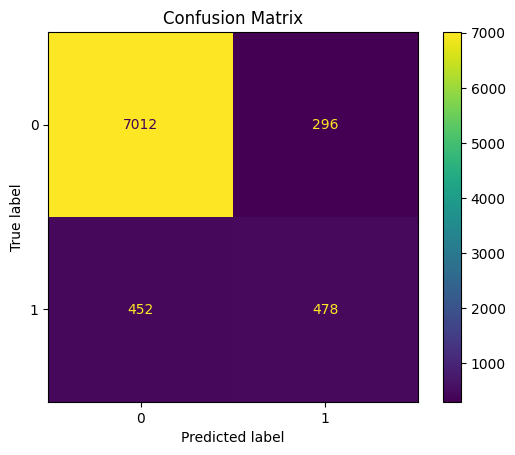

In [221]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [222]:
with mlflow.start_run(run_name="final_evaluation"):
    predictions = grid.predict(X_test)
    report = classification_report(y_test, predictions, output_dict=True)
    
    # Logging explicitly
    mlflow.log_metric("test_accuracy", accuracy_score(y_test, predictions))
    mlflow.log_metric("precision_class_1", report["1"]["precision"])
    mlflow.log_metric("recall_class_1", report["1"]["recall"])
    mlflow.log_metric("f1_class_1", report["1"]["f1-score"])

In [224]:
best_pipeline = grid.best_estimator_

mlflow.sklearn.save_model(
    sk_model=best_pipeline,
    path="app/models/compiled/best_model",
    serialization_format="cloudpickle"
)

[CV 3/3] END multi_models__model=RandomForestClassifier(n_jobs=-1, random_state=3428), multi_models__model__max_depth=None, multi_models__model__n_estimators=50;, score=0.895 total time=   0.5s
[CV 1/3] END multi_models__model=SVC(), multi_models__model__C=0.1, multi_models__model__kernel=linear;, score=0.893 total time=   2.5s
[CV 1/3] END multi_models__model=LogisticRegression(), multi_models__model__penalty=l2;, score=0.900 total time=   0.0s
[CV 2/3] END multi_models__model=LogisticRegression(), multi_models__model__penalty=l2;, score=0.894 total time=   0.0s
[CV 3/3] END multi_models__model=LogisticRegression(), multi_models__model__penalty=l2;, score=0.900 total time=   0.1s
[CV 1/3] END multi_models__model=RandomForestClassifier(n_jobs=-1, random_state=3428), multi_models__model__max_depth=None, multi_models__model__n_estimators=50;, score=0.900 total time=   0.3s
[CV 2/3] END multi_models__model=RandomForestClassifier(n_jobs=-1, random_state=3428), multi_models__model__max_dept